In [1]:
include("dependencies.jl")
include("brute_force.jl")
include("boundary_evolution.jl")

# using ITensors, ITensorMPS, Plots, LaTeXStrings
# using] ProgressMeter
# using Graphs, LinearAlgebra
# using TikzPictures, GraphRecipes
# using HCubature

gr() # or plotly() or pyplot()

function operator_to_vector(op)
    return vec((op)) # op -> transpose(op)
end

function vector_to_operator(vec)
    n = isqrt(length(vec))
    return (reshape(vec, n, n)) # op -> transpose(op)
end


vector_to_operator (generic function with 1 method)

## 2D Ising Stuff

In [7]:
function get_ising_tn(g,N,β;h=0)
    # ising TN with no open indices 
    # g: Graph object
    # N: number of nodes in the graph 
    # β: inverse temp (K_b = 1)
    # J = 1; optional field h
    indmat = [Index(2, "i$(i)j$(j)") for i in 1:N, j in 1:N]
    T = []
    for index = 1:N
        indices = []
        nbrs = neighbors(g, index)
        for nbr in nbrs
            push!(indices,indmat[index,nbr]) ## index --> nbr
        end 
        Ti = ITensor(indices)
        spin = i -> 3 - 2*i ## 1 -> 1, 2 -> -1
        for i1 in 1:2, i2 in 1:2, i3 in 1:2, i4 in 1:2
            s = spin(i1)*spin(i2) + spin(i2)*spin(i3) + spin(i3)*spin(i4) + spin(i4)*spin(i1) 
            s += h*(spin(i1) + spin(i2) + spin(i3) + spin(i4))/2 # divvy by two to avoid double counting
            Ti[i1,i2,i3,i4] = exp(-β * s)
        end 
        # Ti = Ti / norm(Ti) NOT normalizing,
        push!(T,Ti)    
    end 
    return T,indmat
end

function periodic_square_lattice(L::Int)
    g = Graph(L^2)

    # Correct row-major indexing
    idx(i, j) = (i - 1) * L + j
    
    for i in 1:L
        for j in 1:L
            current = idx(i, j)
            right = j < L ? idx(i, j + 1) : idx(i, 1)  # Wrap rightmost to first column
            down = i < L ? idx(i + 1, j) : idx(1, j)    # Wrap bottom to top row
            add_edge!(g, current, right)
            add_edge!(g, current, down)
        end
    end
    return g
end

## analytical free energy, Onsager's solution 

# Define free energy per spin for 2D Ising model with no magnetic field
function free_energy(β::Float64)
    sinh2β = sinh(2 * β)
    cosh2β = cosh(2 * β)
    k = (sinh2β / (cosh2β^2))/2

    integrand(kx, ky) = log(1 - 2 * k * (cos(kx) + cos(ky))) 
    
    integral, _ = hcubature(
        x -> integrand(x[1], x[2]),
        [0.0, 0.0], [π, π],
        rtol=1e-9  # Adjust tolerance for precision
    )
    f = log(2*cosh2β) + integral / (2 * π^2)
    return -f #/β  # multiply by T because f = -T * ( ... )
end

β_c=log(1+sqrt(2))/2

0.44068679350977147

## Sanity check: 2D Ising Phase Transition

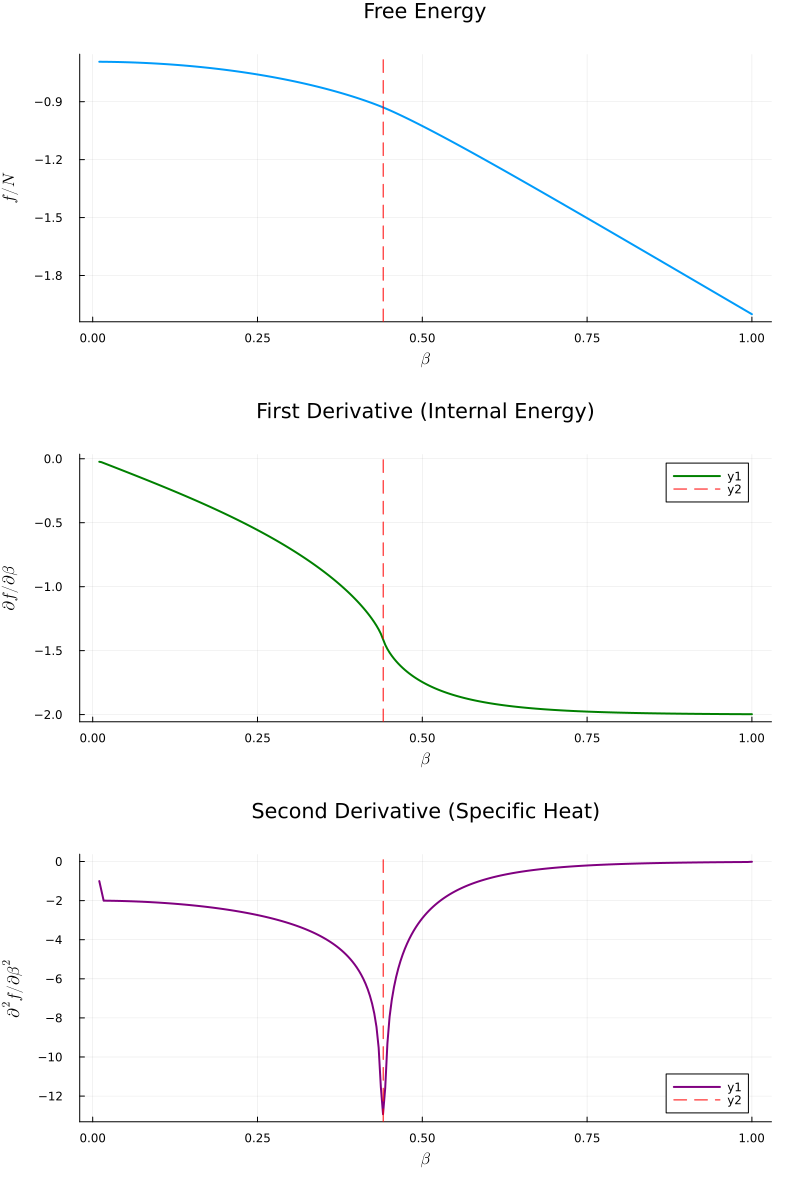

In [ ]:
 

function compute_derivatives(βs, fs)
    Δβ = βs[2] - βs[1]  # Assumes uniform spacing
    
    # First derivative using central differences
    dfdβ = [(fs[i+1] - fs[i-1])/(2Δβ) for i in 2:length(fs)-1]
    dfdβ = vcat([(fs[2] - fs[1])/Δβ], dfdβ, [(fs[end] - fs[end-1])/Δβ])
    
    # Second derivative using central differences
    d2fdβ2 = [(dfdβ[i+1] - dfdβ[i-1])/(2Δβ) for i in 2:length(dfdβ)-1]
    d2fdβ2 = vcat([(dfdβ[2] - dfdβ[1])/Δβ], d2fdβ2, [(dfdβ[end] - dfdβ[end-1])/Δβ])
    
    return dfdβ, d2fdβ2
end
β_c=log(1+sqrt(2))/2
βs = range(.01, 1., length=300)
fs = [free_energy(β) for β in βs]
dfdβ, d2fdβ2 = compute_derivatives(βs, fs)
p1 = plot(βs, fs, xlabel=L"\beta", ylabel=L"f/N", 
            title="Free Energy", linewidth=2, legend=false)
            
vline!([β_c], linestyle=:dash, color=:red)

p2 = plot(βs, dfdβ, xlabel=L"\beta", ylabel=L"\partial f/\partial \beta", 
            title="First Derivative (Internal Energy)", color=:green, linewidth=2)
vline!([β_c], linestyle=:dash, color=:red)

p3 = plot(βs, d2fdβ2, xlabel=L"\beta", ylabel=L"\partial^2 f/\partial \beta^2", 
            title="Second Derivative (Specific Heat)", color=:purple, linewidth=2)
vline!([β_c], linestyle=:dash, color=:red)

plot(p1, p2, p3, layout=(3,1), size=(800,1200), margin=5Plots.mm)


## BP Stuff (not Ising specific)

In [3]:
function get_messages(g,indmat,χ,N)
    ## g: Graph 
    ## indmat: matrix of index sets, {index(i,j)}
    ## χ: bond dim 
    ## N: number of nodes
    messages = Array{ITensor}(undef, N, N)
    for v1 in 1:N
        for v2 in 1:N
            if v1 != v2
                index = indmat[v1,v2]
                # define the message FROM v1 TO v2
                messages[v1, v2] = delta(ComplexF64, index) / sqrt(χ) ##  ITensor([1,0],i1) 
            end
        end
    end
    return messages
end 


function message_passing(T,g,messages,indmat)
    ## g: Graph 
    ## indmat: matrix of index sets, {index(i,j)}
    ## T: tensor network 
    ## messages: matrix of message tensors {μ[v1,v2]}
    edge_tuples = [(src(e),dst(e)) for e in edges(g)]
    Δ = 100 
    while Δ > 1e-6
        δ = 0 
        for e in edge_tuples 
            ## want to update the message from v1 → v2 
            v1, v2 = e 
            update = T[v1]
            for nbr in neighbors(g, v1)
                if nbr != v2 
                    update = update * messages[nbr,v1] * delta(indmat[nbr,v1],indmat[v1,nbr])
                end
            end 
            # println(check_permutation_indices(messages[v1,v2],update))
            δ += norm(messages[v1,v2] - update/norm(update))
            messages[v1,v2] = update/norm(update)
        end 
        
        # backward
        
        for e in edge_tuples 
            ## want to update the message from v1 → v2 
            v2, v1 = e 
            update = T[v1]
            for nbr in neighbors(g, v1)
                if nbr != v2 
                    update = update * messages[nbr,v1]  * delta(indmat[nbr,v1],indmat[v1,nbr])
                end
            end 
            # println(check_permutation_indices(messages[v1,v2],update))
            δ += norm(messages[v1,v2] - update/norm(update))
            messages[v1,v2] = update/norm(update)
        end   
        Δ = δ  
    end 
    return messages 
end 




function mean_free_partition_fn(T,g,messages,indmat,N,these_vertices)
    ## computes the fixed point partition function at the vertices specified by these_vertices 
    ## other things as usual, these_vertices = 1:N gives the BP fixed point
    Z = 1 
    for index = these_vertices
        nbrs = neighbors(g, index)
        Z_local = T[index] 
        for nbr in nbrs
            Z_local *= messages[nbr,index] * delta(indmat[nbr,index],indmat[index,nbr])
        end
        @assert isempty(inds(Z_local))  "T[$index] must be a scalar"
        Z *= scalar(Z_local)
    end
    return Z # -log(Z)/(L^2)
end 


function excited_edge(messages,edge,indmat)
    ## gives the excited projector on the specified edge
    v1,v2 = edge
    # iden = delta(indmat[v1,v2],indmat[v2,v1]) 
    iden = ITensor(indmat[v1,v2],indmat[v2,v1]) 
    for n in 1:dim(indmat[v2,v1])
        iden[indmat[v1,v2]=>n, indmat[v2,v1]=>n] = 1.0 + 0im  # Fill diagonal with ComplexF64 1s
    end
    return iden - messages[v1,v2] * messages[v2,v1]
end 


function loop_contribution(g,loop,messages,T,indmat,N)
    ## gives the excited loop contribution to the partition function at the specified loop, and BP solution at all other edges
    ## loop looks like [(v1,v2),(v2,v3) ...]
    vertices_done = Set()
    loop_contri = 1 
    for edge in loop
        v1, v2 = edge
        loop_contri *= excited_edge(messages,edge,indmat)
        if !(v1 in vertices_done)
            vertices_done = union(vertices_done, v1)
            excited_neighbors = Set([other_vertex for edge in loop if v1 in edge for other_vertex in edge if other_vertex != v1])
            loop_contri *= T[v1]
            for w in neighbors(g, v1)
                if indmat[v1,w] in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v1] * delta(indmat[w,v1],indmat[v1,w])
                end
            end
        end
        if !(v2 in vertices_done)
            vertices_done = union(vertices_done, v2)
            excited_neighbors = Set([other_vertex for edge in loop if v2 in edge for other_vertex in edge if other_vertex != v2])
            loop_contri *= T[v2]
            for w in neighbors(g, v2)
                if indmat[v2,w] in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v2] * delta(indmat[w,v2],indmat[v2,w])
                end
            end
        end
    end
    return scalar(loop_contri) * mean_free_partition_fn(T,g,messages,indmat,N,setdiff(Set(1:N),(vertices_done)))
end

loop_contribution (generic function with 1 method)

## Brute Force Loop

In [4]:
function get_fixed_point_list(T,g,messages,indmat,N)
    ## get a list of the fixed point partition function at each vertex
    Z_l = []
    for index = 1:N
        nbrs = neighbors(g, index)
        Z_local = T[index] 
        for nbr in nbrs
            Z_local *= messages[nbr,index] * delta(indmat[nbr,index],indmat[index,nbr])
        end
        @assert isempty(inds(Z_local))  "T[$index] must be a scalar"
        push!(Z_l,scalar(Z_local))
    end
    return Z_l # -log(Z)/(L^2)
end

function normalize_tensor(T,Z_l,N)
    ## normalize the tensor network by dividing by the BP fixed point
    T_copy = copy(T)
    for index = 1:N
        T_copy[index] /= Z_l[index]
    end
    return T_copy
end

normalize_tensor (generic function with 1 method)

In [ ]:
L = 6
g = periodic_square_lattice(L)
N = L^2
h = 0.

β = .4
T,indmat = get_ising_tn(g,N,β;h=h)
messages = get_messages(g,indmat,2,N)
messages = message_passing(T,g,messages,indmat);

Z_l = get_fixed_point_list(T,g,messages,indmat,N)
Z_product = prod(Z_l)
T_normalized = normalize_tensor(T,Z_l,N)

# Z corrections

correction_l = []
Z = 1
push!(correction_l, Z)
Z += ZCorrection4th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(correction_l, Z)
Z += ZCorrection6th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(correction_l, Z)
Z += ZCorrection7th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(correction_l, Z)
Z += ZCorrection8th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(correction_l, Z)
Z += ZCorrection9th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(correction_l, Z)
Z += ZCorrection10th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(correction_l, Z)

correction_l = correction_l .* Z_product

# log(Z) correction

log_correction_l = []
logZ = 0
push!(log_correction_l, logZ)
logZ += logZCorrection4th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(log_correction_l, logZ)
logZ += logZCorrection6th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(log_correction_l, logZ)
logZ += logZCorrection7th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(log_correction_l, logZ)
logZ += logZCorrection8th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(log_correction_l, logZ)
logZ += logZCorrection9th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(log_correction_l, logZ)
logZ += logZCorrection10th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(log_correction_l, logZ)
log_correction_l = log_correction_l .+ log(Z_product)

# loop_l = loop4th(1,1,L,L)
# loop_contribution(g,loop_l[1],messages,T,indmat,N)

7-element Vector{ComplexF64}:
 61.87443398211359 + 0.0im
 62.39684140570123 + 0.0im
 62.58638129662756 + 0.0im
 62.58638129662756 + 0.0im
 62.65515017055674 + 0.0im
 62.65515017055674 + 0.0im
 62.65497008073176 + 0.0im

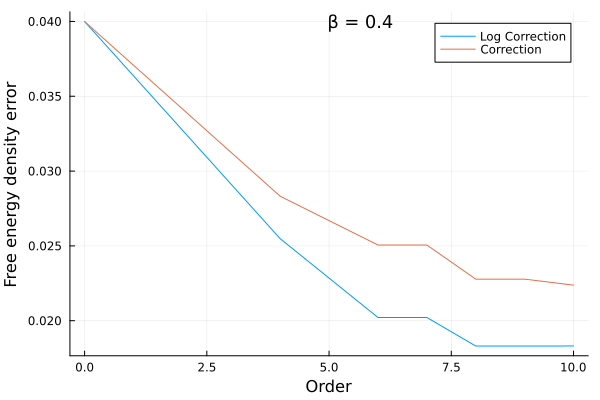

In [ ]:
# plot([0, 4, 6, 7, 8, 9, 10], real(-log_correction_l)/N, label="Log Correction", xlabel="Order", ylabel="Free energy density")
# plot!([0, 4, 6, 7, 8, 9, 10], real(-log.(correction_l))/N, label="Correction")

plot([0, 4, 6, 7, 8, 9, 10], real(-log_correction_l)/N.-2*free_energy(β), label="Log Correction", xlabel="Order", ylabel="Free energy density error")
plot!([0, 4, 6, 7, 8, 9, 10], real(-log.(correction_l))/N.-2*free_energy(β), label="Correction")
# hline!([2*free_energy(β)], linestyle=:dash, color=:red, label="Exact Free Energy")
annotate!(5, maximum(real(-log_correction_l)/N.-2*free_energy(β)), text("β = $β", :left, 12))

## Compare with Boundary MPS

### zero h

In [31]:
# scan over β values
βs = range(.01, 1., length=10)

L = 10
g = periodic_square_lattice(L)
N = L^2
h = 0.

# array of BP fixed point free energy
bp_fixed_point_free_energy = []
# array of loop corrected BP free energy
loop_corrected_free_energy = []
# array of bounary evolution free energy
boundary_evolution_free_energy = []
# exact free energy
exact_free_energy = [2*free_energy(β) for β in βs]

# time for BP fixed point
bp_fixed_point_time = []
# time for loop corrections
loop_correction_time = []
# time for boundary evolution
boundary_evolution_time = []

for β in βs
    println("Current β: ", β)
    time_start = time()

    # compute the BP fixed point
    T,indmat = get_ising_tn(g,N,β;h=0.)
    messages = get_messages(g,indmat,2,N)
    messages = message_passing(T,g,messages,indmat);
    Z_l = get_fixed_point_list(T,g,messages,indmat,N)
    Z_product = prod(Z_l)
    bp_fixed_point_free_energy = vcat(bp_fixed_point_free_energy, real(-log(Z_product))/N)
    bp_fixed_point_time = vcat(bp_fixed_point_time, time() - time_start)
    time_start = time()
    # compute the log loop corrections at 10th order
    T_normalized = normalize_tensor(T,Z_l,N)
    logZ = 0
    logZ += logZCorrection4th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection6th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection7th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection8th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection9th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection10th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += log(Z_product)
    loop_corrected_free_energy = vcat(loop_corrected_free_energy, real(-logZ)/N)
    loop_correction_time = vcat(loop_correction_time, time() - time_start)
    time_start = time()

    # compute the boundary evolution free energy
    peps = generate_ising_peps(L, L, β, h)
    partition_function = contract_peps_no_phys(peps; cutoff=1E-8, maxdim=1024)
    boundary_evolution_free_energy = vcat(boundary_evolution_free_energy, -log(partition_function)/N)
    boundary_evolution_time = vcat(boundary_evolution_time, time() - time_start)
end

Current β: 0.01
Generating Ising PEPS for a 10 x 10 lattice...
PEPS generation complete.
Contracting first row into boundary MPS...
Contracting bulk rows...
  Applying MPO from row 2 / 10
  Applying MPO from row 3 / 10
  Applying MPO from row 4 / 10
  Applying MPO from row 5 / 10
  Applying MPO from row 6 / 10
  Applying MPO from row 7 / 10
  Applying MPO from row 8 / 10
  Applying MPO from row 9 / 10
Contracting with final row...
Contraction finished.
Current β: 0.12
Generating Ising PEPS for a 10 x 10 lattice...
PEPS generation complete.
Contracting first row into boundary MPS...
Contracting bulk rows...
  Applying MPO from row 2 / 10
  Applying MPO from row 3 / 10
  Applying MPO from row 4 / 10
  Applying MPO from row 5 / 10
  Applying MPO from row 6 / 10
  Applying MPO from row 7 / 10
  Applying MPO from row 8 / 10
  Applying MPO from row 9 / 10
Contracting with final row...
Contraction finished.
Current β: 0.23
Generating Ising PEPS for a 10 x 10 lattice...
PEPS generation complet

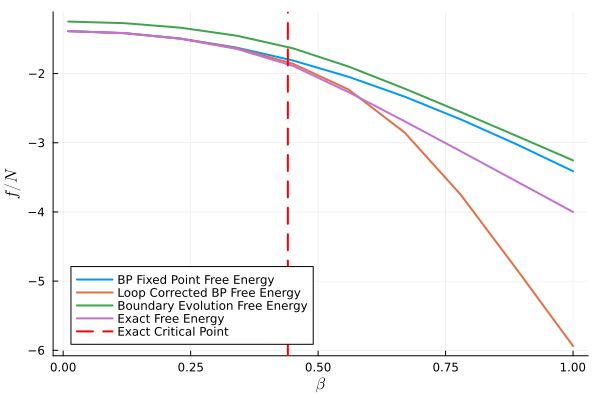

In [33]:
# plot the results
plot(βs, bp_fixed_point_free_energy, label="BP Fixed Point Free Energy", xlabel=L"\beta", ylabel=L"f/N", linewidth=2, legend=:bottomleft)
plot!(βs, loop_corrected_free_energy, label="Loop Corrected BP Free Energy", linewidth=2)
plot!(βs, boundary_evolution_free_energy, label="Boundary Evolution Free Energy", linewidth=2)
plot!(βs, exact_free_energy, label="Exact Free Energy", linewidth=2)
vline!([β_c], linestyle=:dash, color=:red, label="Exact Critical Point", linewidth=2)

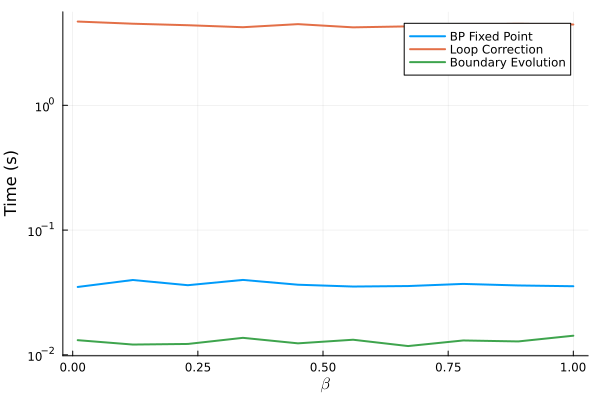

In [ ]:
plot(βs, bp_fixed_point_time, label="BP Fixed Point", xlabel=L"\beta", ylabel="Time (s)", linewidth=2, yscale=:log10)
plot!(βs, loop_correction_time, label="Loop Correction", linewidth=2)
plot!(βs, boundary_evolution_time, label="Boundary Evolution", linewidth=2)
# title!("Computation Time vs β")

### Compare Log(Z) order

Generating Ising PEPS for a 6 x 6 lattice...
PEPS generation complete.
Contracting first row into boundary MPS...
Contracting bulk rows...
  Applying MPO from row 2 / 6
  Applying MPO from row 3 / 6
  Applying MPO from row 4 / 6
  Applying MPO from row 5 / 6
Contracting with final row...
Contraction finished.
PEPS generation complete.
Contracting first row into boundary MPS...
Contracting bulk rows...
  Applying MPO from row 2 / 6
  Applying MPO from row 3 / 6
  Applying MPO from row 4 / 6
  Applying MPO from row 5 / 6
Contracting with final row...
Contraction finished.


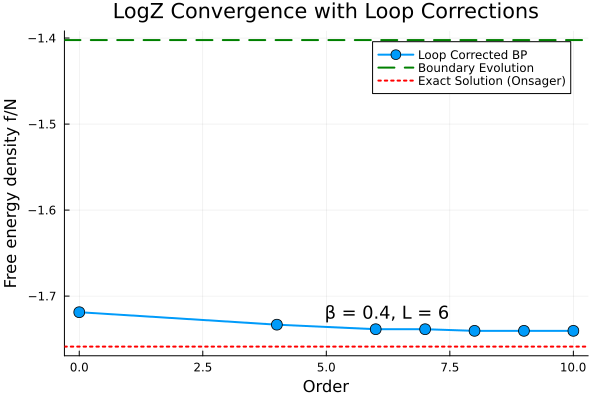

In [ ]:
# Plot logZ for varying orders of correction up to 10, compare with boundary evolution and exact solution
# Using parameters from cell 9 (L=6, β=0.4, h=0)

L = 6
g = periodic_square_lattice(L)
N = L^2
h = 0.
β = .4

# Set up the system
T,indmat = get_ising_tn(g,N,β;h=h)
messages = get_messages(g,indmat,2,N)
messages = message_passing(T,g,messages,indmat);
Z_l = get_fixed_point_list(T,g,messages,indmat,N)
Z_product = prod(Z_l)
T_normalized = normalize_tensor(T,Z_l,N)

# Compute logZ corrections for each order
orders = [0, 4, 6, 7, 8, 9, 10]
logZ_corrections = []

# Order 0 (BP fixed point)
logZ = 0
push!(logZ_corrections, logZ + log(Z_product))

# Order 4
logZ += logZCorrection4th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(logZ_corrections, logZ + log(Z_product))

# Order 6
logZ += logZCorrection6th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(logZ_corrections, logZ + log(Z_product))

# Order 7
logZ += logZCorrection7th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(logZ_corrections, logZ + log(Z_product))

# Order 8
logZ += logZCorrection8th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(logZ_corrections, logZ + log(Z_product))

# Order 9
logZ += logZCorrection9th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(logZ_corrections, logZ + log(Z_product))

# Order 10
logZ += logZCorrection10th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
push!(logZ_corrections, logZ + log(Z_product))

# Convert to free energy density
loop_free_energies = real.(-logZ_corrections) ./ N

# Compute boundary evolution free energy
peps = generate_ising_peps(L, L, β, h)
partition_function = contract_peps_no_phys(peps; cutoff=1E-8, maxdim=1024)
boundary_evolution_fe = -log(partition_function) / N

# Exact free energy (Onsager's solution)
exact_fe = 2 * free_energy(β)

# Plot comparison
plot(orders, loop_free_energies, label="Loop Corrected BP", xlabel="Order", ylabel="Free energy density f/N", 
     marker=:circle, linewidth=2, markersize=6)
hline!([boundary_evolution_fe], linestyle=:dash, color=:green, linewidth=2, 
       label="Boundary Evolution")
hline!([exact_fe], linestyle=:dot, color=:red, linewidth=2, 
       label="Exact Solution (Onsager)")

# Add annotation
annotate!(5, maximum(loop_free_energies), text("β = $β, L = $L", :left, 12))
# legend!(:bottomright)
title!("LogZ Convergence with Loop Corrections")


In [44]:

# Plot corrected log(Z) as a function of β with multiple lines for different orders

βs = range(.01, 1.5, length=30)
L = 6
g = periodic_square_lattice(L)
N = L^2
h = 0.

# Initialize arrays to store results for each order
bp_free_energies = []
order4_free_energies = []
order6_free_energies = []
order7_free_energies = []
order8_free_energies = []
order9_free_energies = []
order10_free_energies = []
exact_free_energies = [2*free_energy(β) for β in βs]

for β in βs
    println("Current β: ", β)
    
    # Set up the system
    T,indmat = get_ising_tn(g,N,β;h=h)
    messages = get_messages(g,indmat,2,N)
    messages = message_passing(T,g,messages,indmat);
    Z_l = get_fixed_point_list(T,g,messages,indmat,N)
    Z_product = prod(Z_l)
    T_normalized = normalize_tensor(T,Z_l,N)
    
    # BP fixed point (order 0)
    bp_fe = real(-log(Z_product))/N
    push!(bp_free_energies, bp_fe)
    
    # Compute corrections incrementally
    logZ = 0
    
    # Order 4
    logZ += logZCorrection4th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    order4_fe = real(-(logZ + log(Z_product)))/N
    push!(order4_free_energies, order4_fe)
    
    # Order 6
    logZ += logZCorrection6th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    order6_fe = real(-(logZ + log(Z_product)))/N
    push!(order6_free_energies, order6_fe)
    
    # Order 7
    logZ += logZCorrection7th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    order7_fe = real(-(logZ + log(Z_product)))/N
    push!(order7_free_energies, order7_fe)
    
    # Order 8
    logZ += logZCorrection8th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    order8_fe = real(-(logZ + log(Z_product)))/N
    push!(order8_free_energies, order8_fe)
    
    # Order 9
    logZ += logZCorrection9th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    order9_fe = real(-(logZ + log(Z_product)))/N
    push!(order9_free_energies, order9_fe)
    
    # Order 10
    logZ += logZCorrection10th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    order10_fe = real(-(logZ + log(Z_product)))/N
    push!(order10_free_energies, order10_fe)
end

Current β: 0.01
Current β: 0.06137931034482759
Current β: 0.11275862068965517
Current β: 0.16413793103448276
Current β: 0.21551724137931033
Current β: 0.26689655172413795
Current β: 0.3182758620689655
Current β: 0.3696551724137931
Current β: 0.4210344827586207
Current β: 0.4724137931034483
Current β: 0.5237931034482759
Current β: 0.5751724137931035
Current β: 0.626551724137931
Current β: 0.6779310344827586
Current β: 0.7293103448275862
Current β: 0.7806896551724138
Current β: 0.8320689655172414
Current β: 0.883448275862069
Current β: 0.9348275862068965
Current β: 0.9862068965517241
Current β: 1.0375862068965518
Current β: 1.0889655172413792
Current β: 1.140344827586207
Current β: 1.1917241379310344
Current β: 1.243103448275862
Current β: 1.2944827586206897
Current β: 1.3458620689655172
Current β: 1.3972413793103449
Current β: 1.4486206896551723
Current β: 1.5


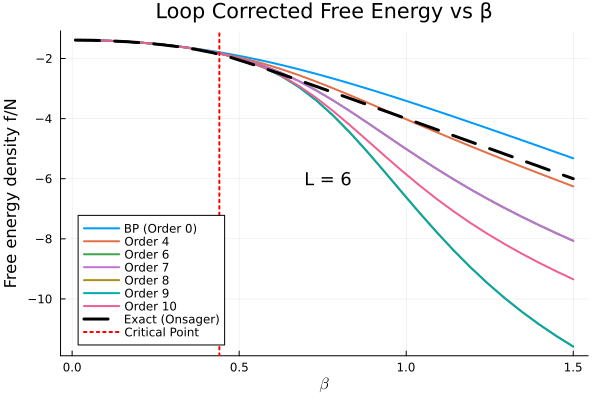

In [45]:
# Create the plot
plot(βs, bp_free_energies, label="BP (Order 0)", xlabel=L"\beta", ylabel="Free energy density f/N", 
     linewidth=2, legend=:bottomleft)
plot!(βs, order4_free_energies, label="Order 4", linewidth=2)
plot!(βs, order6_free_energies, label="Order 6", linewidth=2)
plot!(βs, order7_free_energies, label="Order 7", linewidth=2)
plot!(βs, order8_free_energies, label="Order 8", linewidth=2)
plot!(βs, order9_free_energies, label="Order 9", linewidth=2)
plot!(βs, order10_free_energies, label="Order 10", linewidth=2)
plot!(βs, exact_free_energies, label="Exact (Onsager)", linewidth=3, linestyle=:dash, color=:black)

# Add critical temperature line
vline!([β_c], linestyle=:dot, color=:red, linewidth=2, label="Critical Point")

title!("Loop Corrected Free Energy vs β")
annotate!(0.7, minimum(exact_free_energies), text("L = $L", :left, 12))

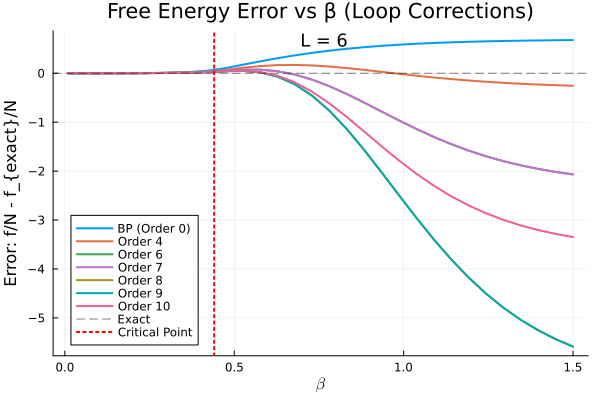

In [50]:
# Plot error (loop corrected - exact) for all orders as a function of β

# Calculate errors for each order
bp_error = bp_free_energies .- exact_free_energies
order4_error = order4_free_energies .- exact_free_energies
order6_error = order6_free_energies .- exact_free_energies
order7_error = order7_free_energies .- exact_free_energies
order8_error = order8_free_energies .- exact_free_energies
order9_error = order9_free_energies .- exact_free_energies
order10_error = order10_free_energies .- exact_free_energies

# Create error plot
plot(βs, bp_error, label="BP (Order 0)", xlabel=L"\beta", ylabel="Error: f/N - f_{exact}/N", 
     linewidth=2, legend=:bottomleft)
plot!(βs, order4_error, label="Order 4", linewidth=2)
plot!(βs, order6_error, label="Order 6", linewidth=2)
plot!(βs, order7_error, label="Order 7", linewidth=2)
plot!(βs, order8_error, label="Order 8", linewidth=2)
plot!(βs, order9_error, label="Order 9", linewidth=2)
plot!(βs, order10_error, label="Order 10", linewidth=2)

# Add zero line for reference
hline!([0], linestyle=:dash, color=:black, linewidth=1, alpha=0.5, label="Exact")

# Add critical temperature line
vline!([β_c], linestyle=:dot, color=:red, linewidth=2, label="Critical Point")

title!("Free Energy Error vs β (Loop Corrections)")
annotate!(0.7, maximum(bp_error), text("L = $L", :left, 12))

### finite h

In [30]:
# scan over β values
βs = range(.01, 2., length=10)

L = 10
g = periodic_square_lattice(L)
N = L^2
h = 0.1

# array of BP fixed point free energy
bp_fixed_point_free_energy = []
# array of loop corrected BP free energy
loop_corrected_free_energy = []
# array of bounary evolution free energy
boundary_evolution_free_energy = []
# exact free energy
exact_free_energy = [2*free_energy(β) for β in βs]

# time for BP fixed point
bp_fixed_point_time = []
# time for loop corrections
loop_correction_time = []
# time for boundary evolution
boundary_evolution_time = []

for β in βs
    println("Current β: ", β)
    time_start = time()

    # compute the BP fixed point
    T,indmat = get_ising_tn(g,N,β;h=0.)
    messages = get_messages(g,indmat,2,N)
    messages = message_passing(T,g,messages,indmat);
    Z_l = get_fixed_point_list(T,g,messages,indmat,N)
    Z_product = prod(Z_l)
    bp_fixed_point_free_energy = vcat(bp_fixed_point_free_energy, real(-log(Z_product))/N)
    bp_fixed_point_time = vcat(bp_fixed_point_time, time() - time_start)
    time_start = time()
    # compute the log loop corrections at 10th order
    T_normalized = normalize_tensor(T,Z_l,N)
    logZ = 0
    logZ += logZCorrection4th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection6th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection7th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection8th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection9th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection10th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += log(Z_product)
    loop_corrected_free_energy = vcat(loop_corrected_free_energy, real(-logZ)/N)
    loop_correction_time = vcat(loop_correction_time, time() - time_start)
    time_start = time()

    # compute the boundary evolution free energy
    # peps = generate_ising_peps(L, L, β, h)
    # partition_function = contract_peps_no_phys(peps; cutoff=1E-8, maxdim=1024)
    # boundary_evolution_free_energy = vcat(boundary_evolution_free_energy, -log(partition_function)/N)
    # boundary_evolution_time = vcat(boundary_evolution_time, time() - time_start)
end

Current β: 0.01
Current β: 0.2311111111111111
Current β: 0.45222222222222225
Current β: 0.6733333333333333
Current β: 0.8944444444444445
Current β: 1.1155555555555556
Current β: 1.3366666666666667
Current β: 1.5577777777777777
Current β: 1.778888888888889
Current β: 2.0


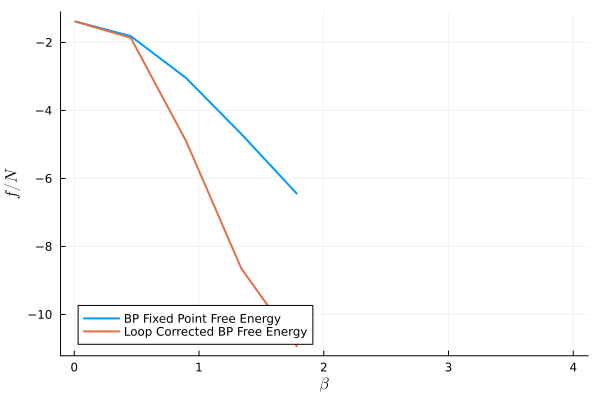

In [28]:
# plot the results
plot(βs, bp_fixed_point_free_energy, label="BP Fixed Point Free Energy", xlabel=L"\beta", ylabel=L"f/N", linewidth=2, legend=:bottomleft)
plot!(βs, loop_corrected_free_energy, label="Loop Corrected BP Free Energy", linewidth=2)
# plot!(βs, boundary_evolution_free_energy, label="Boundary Evolution Free Energy", linewidth=2)
# plot!(βs, exact_free_energy, label="Exact Free Energy", linewidth=2)
# vline!([β_c], linestyle=:dash, color=:red, label="Exact Critical Point", linewidth=2)

## Scan h with loop

Current h: 0.0
Current h: 
Current h: 0.5
Current h: 1.00.5
Current h: 1.0
Current h: 
Current h: 1.5
Current h: 2.01.5
Current h: 2.0
Current h: 
Current h: 2.5
Current h: 3.02.5
Current h: 3.0
Current h: 
Current h: 3.5
Current h: 4.03.5
Current h: 4.0
Current h: 
Current h: 4.5
Current h: 5.04.5
Current h: 5.0
Current h: 
Current h: 5.5
Current h: 6.05.5
Current h: 6.0
Current h: 
Current h: 6.5
Current h: 7.06.5
Current h: 7.0
Current h: 
Current h: 7.5
Current h: 8.07.5
Current h: 8.0
Current h: 
Current h: 8.5
Current h: 9.08.5
Current h: 9.0
Current h: 
Current h: 9.5
Current h: 10.0
9.5
Current h: 10.0


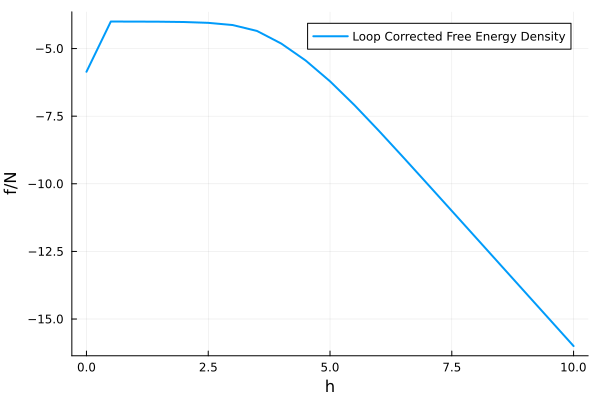

In [15]:
# Scan h from 0 to 10 at fixed β=1 using log loop expansion
β = 1.0
L = 6
N = L^2
hvals = range(0, 10, length=21)

log_correction_l = []
for h in hvals
    println("Current h: ", h)
    g = periodic_square_lattice(L)
    T,indmat = get_ising_tn(g,N,β;h=h)
    messages = get_messages(g,indmat,2,N)
    messages = message_passing(T,g,messages,indmat);
    Z_l = get_fixed_point_list(T,g,messages,indmat,N)
    Z_product = prod(Z_l)
    T_normalized = normalize_tensor(T,Z_l,N)
    logZ = 0
    logZ += logZCorrection4th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection6th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection7th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection8th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection9th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection10th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += log(Z_product)
    push!(log_correction_l, real(-logZ)/N)
end

plot(hvals, log_correction_l, label="Loop Corrected Free Energy Density", xlabel="h", ylabel="f/N", linewidth=2)


In [31]:
# Scan h from 0 to 10 at fixed β=1: BP fixed point and log loop correction
β = 2.0
L = 6
N = L^2
hvals = range(0.1, 10, length=21)

bp_fixed_point_free_energy = []
log_correction_l = []
for h in hvals
    println("Current h: ", h)
    g = periodic_square_lattice(L)
    T,indmat = get_ising_tn(g,N,β;h=h)
    messages = get_messages(g,indmat,2,N)
    messages = message_passing(T,g,messages,indmat);
    Z_l = get_fixed_point_list(T,g,messages,indmat,N)
    Z_product = prod(Z_l)
    push!(bp_fixed_point_free_energy, real(-log(Z_product))/N)
    T_normalized = normalize_tensor(T,Z_l,N)
    logZ = 0
    logZ += logZCorrection4th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection6th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection7th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection8th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection9th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += logZCorrection10th(loop_contribution,L,L,g,messages,T_normalized,indmat,N)
    logZ += log(Z_product)
    push!(log_correction_l, real(-logZ)/N)
end

Current h: 0.1
Current h: 0.595
Current h: 1.090.595
Current h: 1.09
Current h: 
Current h: 1.585
Current h: 2.081.585
Current h: 2.08
Current h: 
Current h: 2.575
Current h: 3.072.575
Current h: 3.07
Current h: 
Current h: 3.565
Current h: 4.063.565
Current h: 4.06
Current h: 
Current h: 4.555
Current h: 5.054.555
Current h: 5.05
Current h: 
Current h: 5.545
Current h: 6.045.545
Current h: 6.04
Current h: 
Current h: 6.535
Current h: 7.036.535
Current h: 7.03
Current h: 
Current h: 7.525
Current h: 8.027.525
Current h: 8.02
Current h: 
Current h: 8.515
Current h: 9.018.515
Current h: 9.01
Current h: 
Current h: 9.505
Current h: 10.0
9.505
Current h: 10.0


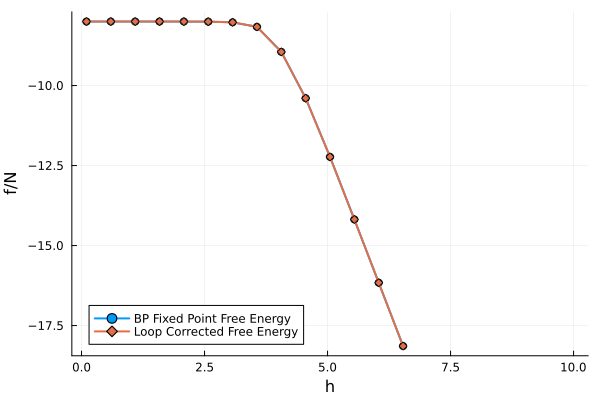

In [32]:
plot(hvals, bp_fixed_point_free_energy, label="BP Fixed Point Free Energy", xlabel="h", ylabel="f/N", linewidth=2, marker=:circle)
plot!(hvals, log_correction_l, label="Loop Corrected Free Energy", linewidth=2, marker=:diamond)

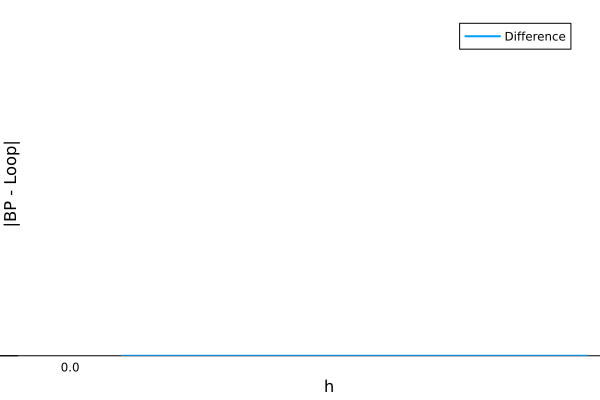

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/frankzhang/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/frankzhang/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /Users/frankzhang/.julia/packages/Plots/FFuQi/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/frankzhang/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/frankzhang/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /Users/frankzhang/.julia/packages/Plots/FFuQi/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/frankzhang/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/frankzhang/.julia/packages/PlotUtils/dVEMd/s

In [33]:
plot(hvals, abs.(bp_fixed_point_free_energy .- log_correction_l), yscale=:log10, xlabel="h", ylabel="|BP - Loop|", label="Difference", linewidth=2)